In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


Extracting the files from the zip file.

In [4]:
from io import BytesIO
from zipfile import ZipFile
zipfile = ZipFile('/content/archive.zip')
zipfile.extractall(path = './brainMriImages')

Initially, we displayed a few images to see the shape of images in our dataset.  

(201, 173, 3)


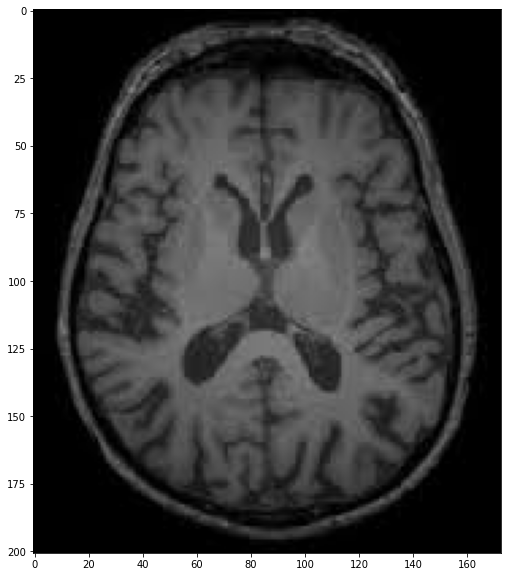

In [5]:
plt.figure(figsize=(16,10))
import matplotlib.image as mpimg

img=imread('/content/brainMriImages/brain_tumor_dataset/no/10 no.jpg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

The above image had 3 channels but the below image did'nt have any channels.

(630, 630)


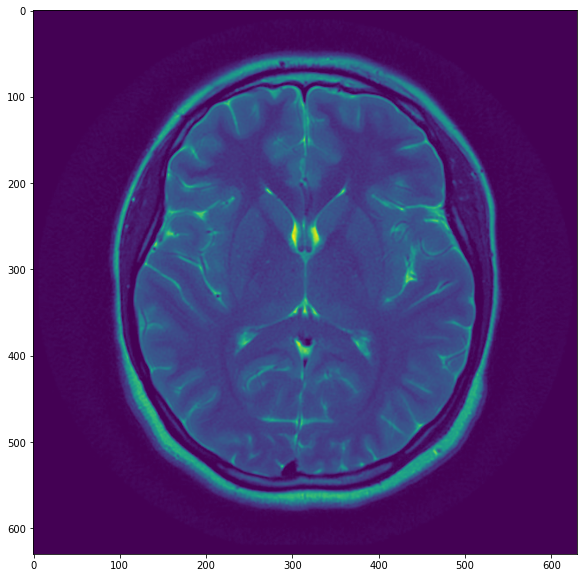

In [6]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/no/1 no.jpeg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

(218, 180)


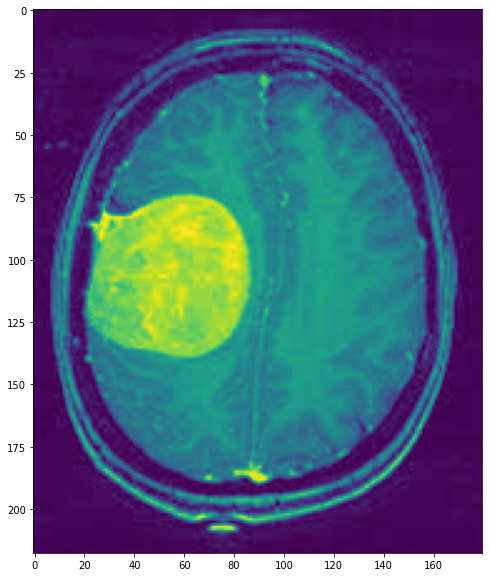

In [7]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/yes/Y1.jpg')[:,:,0]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

(360, 319)


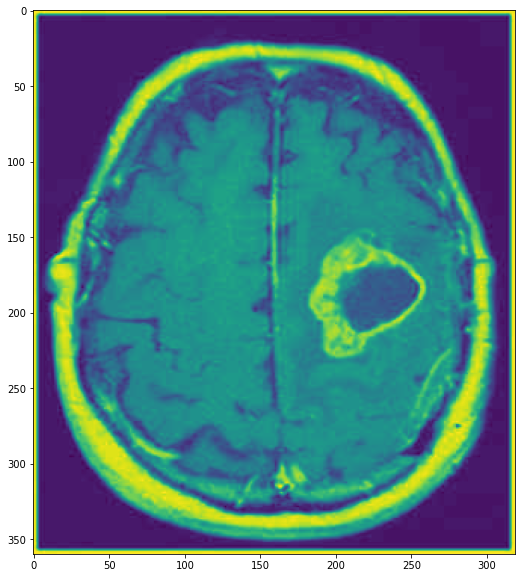

In [8]:
plt.figure(figsize=(16,10))
img=imread('/content/brainMriImages/brain_tumor_dataset/yes/Y10.jpg')[:,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

To extract all images in the file path 'no', we used the glob function.

In [9]:
images= glob('/content/brainMriImages/brain_tumor_dataset/no/*')

In [10]:
len(images)

98

To extract all images in the file path 'yes', we used the glob function. We combined both the yes and no images together.

In [11]:
images=images+glob('/content/brainMriImages/brain_tumor_dataset/yes/*')

In [12]:
len(images)

253

We shuffled the images for randomness.

In [13]:
from random import shuffle 
shuffle(images)



In [14]:
images

['/content/brainMriImages/brain_tumor_dataset/yes/Y96.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y168.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/11 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y170.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y16.JPG',
 '/content/brainMriImages/brain_tumor_dataset/no/10 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/N3.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y108.jpg',
 '/content/brainMriImages/brain_tumor_dataset/no/30 no.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y116.JPG',
 '/content/brainMriImages/brain_tumor_dataset/no/No14.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y113.JPG',
 '/content/brainMriImages/brain_tumor_dataset/no/N22.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y53.jpg',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y247.JPG',
 '/content/brainMriImages/brain_tumor_dataset/yes/Y161.JPG',
 '/content/brainMriImages/brain_t

We checked the shape of every image and found every image do be of differnet size and shape. There are cases where an image had 3 channels, 4 channels and no channels. There were even cases where channels existed at a different position. For modeling we need to make sure that every image is same size

In [15]:
for i in images:
  print(imread(i).shape)

(938, 864, 3)
(300, 263, 3)
(168, 300, 3)
(355, 290, 3)
(360, 313, 3)
(201, 173, 3)
(275, 220)
(1200, 1059, 3)
(242, 208, 3)
(269, 249, 3)
(340, 339, 3)
(312, 254, 3)
(326, 276, 3)
(219, 230, 3)
(338, 248, 3)
(351, 273, 3)
(355, 272, 3)
(340, 291, 3)
(238, 212, 3)
(234, 216, 3)
(360, 319)
(251, 204, 3)
(519, 456, 3)
(4, 454, 442)
(225, 225, 3)
(173, 189, 3)
(725, 728)
(380, 310, 3)
(340, 314, 3)
(348, 287, 3)
(344, 279, 3)
(323, 276, 3)
(355, 294, 3)
(225, 225, 3)
(251, 201, 3)
(198, 150, 3)
(283, 231, 3)
(250, 201, 3)
(231, 218, 3)
(938, 911, 3)
(251, 201, 3)
(251, 201, 3)
(270, 229, 3)
(275, 220)
(929, 634, 3)
(380, 294, 3)
(960, 781, 3)
(294, 250)
(353, 300, 3)
(168, 300, 3)
(630, 504, 3)
(201, 173, 3)
(620, 620, 3)
(325, 300)
(351, 262, 3)
(530, 380, 3)
(393, 350, 3)
(630, 630, 3)
(347, 300, 3)
(446, 450, 3)
(680, 680, 3)
(349, 278, 3)
(359, 300, 3)
(324, 272, 3)
(236, 213, 3)
(233, 215, 3)
(247, 204, 3)
(442, 442)
(253, 200, 3)
(225, 225, 3)
(255, 197, 3)
(357, 283, 3)
(264, 210, 

Extracting images which had 4 channels at the first position in shape.

In [16]:
for i in images:
  if(imread(i).shape[0]==4):
    print(i,)

/content/brainMriImages/brain_tumor_dataset/no/No18.jpg
/content/brainMriImages/brain_tumor_dataset/no/No17.jpg
/content/brainMriImages/brain_tumor_dataset/no/no.jpg
/content/brainMriImages/brain_tumor_dataset/no/No15.jpg
/content/brainMriImages/brain_tumor_dataset/no/no 96.jpg


torch.Size([4, 400, 393])
torch.Size([1, 4, 512, 512])


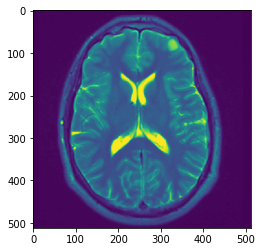

In [17]:
img=imread('/content/brainMriImages/brain_tumor_dataset/no/No17.jpg')

img=img/255.0           # to convert RGB images which are in range [0,255] to [0.0,1.0]
img=torch.tensor(img)   # converting numpy array into tensor object
print(img.shape)
img=img.unsqueeze(0)    # adding a new dimension by filling with zero's
img = F.interpolate(img, (512, 512))  # Down/up samples the input to either the given size or the given scale_factor 
print(img.shape)
imgplot = plt.imshow(img[0,0,:,:]) # displaying the image using imshow() function
plt.show()


In [18]:
img.shape

torch.Size([1, 4, 512, 512])

Creating a BrainImages object.

In [19]:
class BrainImages(Dataset):
  
  def __init__(self, paths):
      self.paths = paths
  
  
  def __len__(self):
      return len(self.paths)
  
  
  def __getitem__(self, index):
      image_path = self.paths[index]
      if 'yes' in image_path:
        cls=1                           # Assiging labels to each image based on their path. yes is given a class '1' and no is '0'
      else:
        cls=0 

      if len(imread(image_path).shape)==3 and imread(image_path).shape[0]==4:  # Images having shape length 3 and having first element as 4 (ex: 4,255,255)
        img=imread(image_path)
        img=np.moveaxis(img,0,-1)   #shifting element at poisition 0 to -1 (4,255,255---> 255,255,4)
        img=img[:,:,0]              # nulling the element at position -1 (255,255)
      elif len(imread(image_path).shape)==3:
        img=imread(image_path)[:,:,0]
      else:
        img=imread(image_path)
      

      img=img/255.0                # to convert RGB images which are in range [0,255] to [0.0,1.0]
      #img=img.astype('float')
      
      img=torch.tensor(img)        # converting numpy array to tensor
      #img=img.type(torch.cuda.FloatTensor)
      img=img.unsqueeze(0)         # adding a new dimension for channel 
      img = F.interpolate(img.unsqueeze(0), (224, 224))  # Down/up samples the input to either the given size or the given scale_factor.
      dim = np.zeros((224,224))     # Since we want to comapre our novel model with a pre-trained model which accepts 3 channels as input,
      R = np.stack((img[0,0,:],dim, dim), axis=0) #we are adding 2 extra channels.
      
      return (R,cls)

In [20]:
paths=images

In [21]:
data = BrainImages(paths)

In [22]:
len(data)  # To verify all our images from the dataset have been extracted, labelled with correct class and converted to required shape.

253

Total number of images from the dataset is 155 yes + 98 No = 253


Making sure our images have the desired shape of (Channels=3,width=224, height=224)

Width and Height values were chosen based on requirements for pre-trained model. 

In [23]:
data[0][0].shape

(3, 224, 224)

### Data Augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

There happen to exist a number of ways to augment data. We chose a few techniques like rotate (rotates the image at a given angle), AffineTransformfrom (transformation preserving collinearity) and warp (warps the image) using the **skimage.transform** module.

In [24]:
from skimage.transform import rotate, AffineTransform, warp
import skimage.io as io

Checking out how the rotate technique works on the image.

(3, 224, 224)


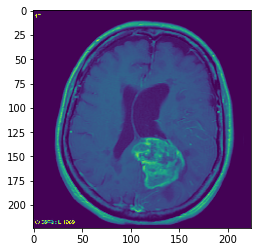

(224, 224)


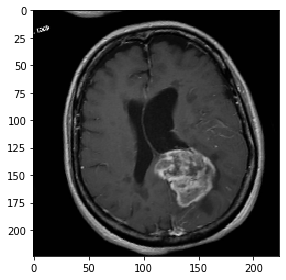

In [25]:
print(data[0][0].shape)
imgplot = plt.imshow(data[0][0][0,:])
plt.show()
rotated = rotate(data[0][0][0,:], angle=15, mode = 'wrap')
 #plot the rotated 
print(rotated.shape)
io.imshow(rotated)